In [1]:
import unittest 
import numpy as np
import numpy.linalg as la
from numpy import array, pi, cos, sin, sqrt, linspace
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib notebook

import time

from Fullerene_GeometryFunctions.py import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) 

np.random.seed(22)

NA = np.newaxis;


# Import data

In [7]:
from C60ih import *
print(points_opt.shape)
print(cubic_neighbours.shape)
print(pentagons.shape)
print(hexagons.shape)

(60, 3)
(60, 3)
(12, 5)
(20, 6)


<IPython.core.display.Javascript object>


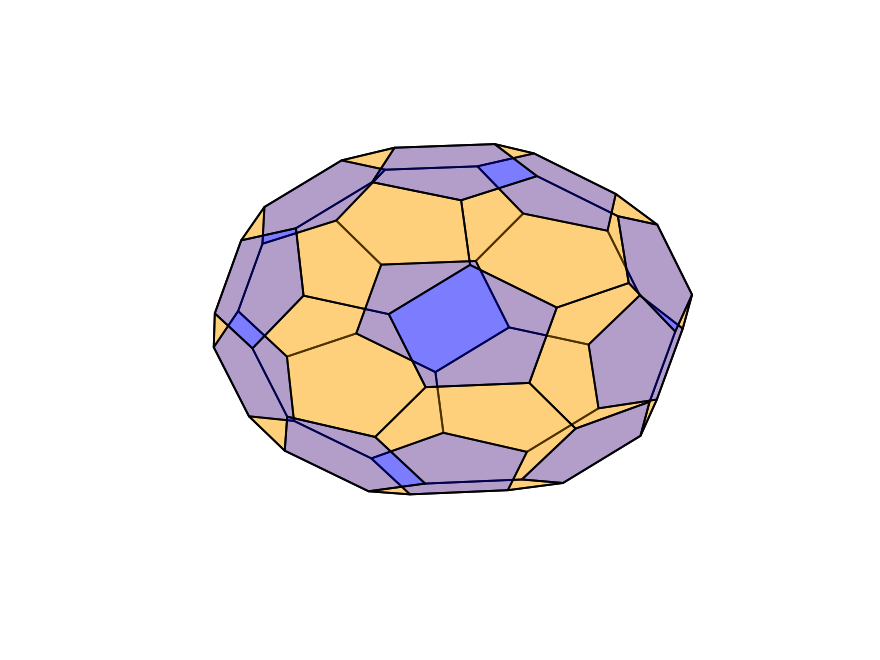

DFT m062x optimized geometry


In [9]:
geom = read_geometry("C60_Ih_m062x_freq_symIh.log")
plotting_faces(geom,pentagons,hexagons,ap=0.3,ah=0.3,ax_off=True)
print('DFT m062x optimized geometry')

# Force field CGM

### Calculate force const. from face information.

In [12]:
## General force parameters
R0,ang0,dih0,ang0_p,ang0_m,dih_a,dih_m,dih_p,fR,fang,fdih,fang_p,fang_m,fdih_a,fdih_m,fdih_p = Parameters_from_geometry(face_right,cubic_neighbours,False)

## Seminario Force Parameters, for C60Ih
# R0,ang0,dih0,ang0_p,ang0_m,dih_a,dih_m,dih_p,fR,fang,fdih,fang_p,fang_m,fdih_a,fdih_m,fdih_p = Parameters_from_geometry(face_right,cubic_neighbours,True)

k0 = array([R0,ang0,dih0,ang0_p,ang0_m,dih_a,dih_m,dih_p])
f0 = array([fR,fang,fdih,fang_p,fang_m,fdih_a,fdih_m,fdih_p])

In [13]:
def conjugate_gradient(X, neighbours,next_on_face, prev_on_face,k0,f0, N_max,UseAll): 

    d = -gradient(X,neighbours,next_on_face, prev_on_face,k0,f0,UseAll)
    r0 = d; #initial residual 
    d /= la.norm(d) # Normalized initial search direction
    
    #Save geometries for plotting
    xGeom = np.empty(0)  
    
    
    dnorm = la.norm(d) #initial dnorm = 1.
    
    N=0;
    while dnorm > 1e-7: ## Stop if gradient gets bellow threshold.

        N+=1
        xGeom = np.append(xGeom,X) ## Save geometries.
        
        ## Bisection line search
        alpha, X_1, r1 = Bisection_search(d,X,neighbours,next_on_face, prev_on_face,k0,f0,0,0.00001,1000,1e-10,N,UseAll) 
            
        ##Polak-Ribiére
        beta = max(PolakRibiere(r0,r1),0)

          ##Steepest descend
#         beta = 0 

          ##Fletcher-Reeves
#         beta = FletcherReeves(r0,r1)

        ## If energy is increased, start over with beta = 0.
        if energy(X_1,neighbours,k0,f0) > energy(X,neighbours,k0,f0):
            beta = 0  
            X_1  = X
            r1   = r0

        
        d = r1 + beta*d ## Conjugate the search direction
        d /= la.norm(d) #Normalizes new search direction
        
        
        r0 = r1 
        X = X_1
        
        
        ## If the number of itereations goes above 10*Natoms stop.
        dnorm = la.norm((r1))
        if N == N_max*10: 
            print(dnorm)
            return X, r1, N, xGeom  
        
        
    return X, r1, N, xGeom

## Optimize C60 initial geometry

In [14]:
## Wu and Wirz force fields
# X_wu, _, _, All_X_wu      = conjugate_gradient(points_start, cubic_neighbours,next_on_face, prev_on_face,k0,f0, len(points_start),0)
# X_wirz, _, _, All_X_wirz  = conjugate_gradient(points_start, cubic_neighbours,next_on_face, prev_on_face,k0,f0, len(points_start),1)


In [22]:
## corrected Wirz method
X, d_end, N_itt, All_X  = conjugate_gradient(points_start, cubic_neighbours,next_on_face, prev_on_face,k0,f0, len(points_start),2)
print(f'Energy end:    {energy(X,cubic_neighbours,k0,f0)}')
print(f'gradient norm: {la.norm(d_end)}')
print(f'Iterations until convergance: {N_itt}')


Energy end:    1.4696698118868889e-10
gradient norm: 9.920042640351575e-08
Iterations until convergance: 251


In [19]:
## Calculate intrinsic properties of DFT and FF optimized geometries
Rdft, Ddft = edge_displacements(geom,cubic_neighbours)
Ruv, Duv = edge_displacements(X,cubic_neighbours)

ang_dft = corner_cos_angles(Ddft)
ang = corner_cos_angles(Duv)

dih_dft = dihedral_cos_angles(Ddft,Rdft)
dih = dihedral_cos_angles(Duv,Ruv)

N = len(points_start)

print('RMS-errors')
print(f'R:        {np.sum((Rdft - Ruv)**2)/(N)     } Angstrom\n'  )
print(f'angle:    {np.sum((ang_dft - ang)**2)/(N)} Degrees\n'  )
print(f'dih:      {np.sum((dih_dft - dih)**2)/(N)} Degrees'  )

RMS-errors
R:        0.0003637172011608949 Angstrom

angle:    2.7984977612202196e-10 Degrees

dih:      1.1698027653005154e-07 Degrees


### Plotting energies at each iteration

<IPython.core.display.Javascript object>


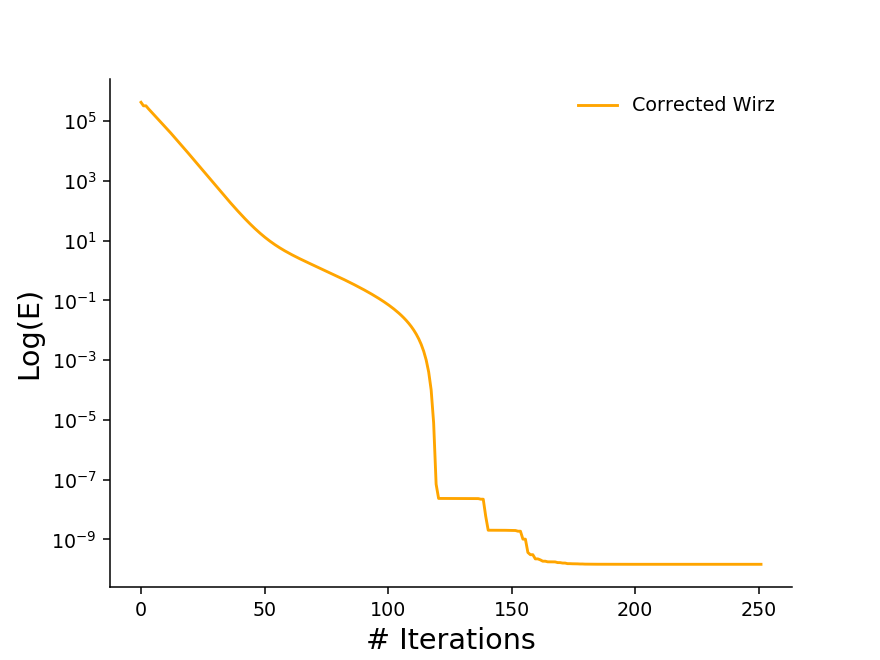

In [25]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

    
XG= All_X.reshape(N_itt,len(points_opt),3)
Geometry_Energy = np.empty(0)

for i in range(len(XG)):
    Geometry_Energy = np.append(Geometry_Energy,energy(XG[i,:,:],cubic_neighbours,k0,f0))

    
fig = plt.figure()
Itt = np.linspace(0,N_itt,N_itt)

ax = plt.subplot(111)

ax.semilogy(Itt,Geometry_Energy,label='Corrected Wirz',color='orange')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Log(E)',fontsize=15)
ax.set_xlabel('# Iterations',fontsize=15)

ax.legend(loc='upper right',edgecolor='k',frameon=False)

plt.show()

## Geometry of Force field optimized C60Ih

<IPython.core.display.Javascript object>


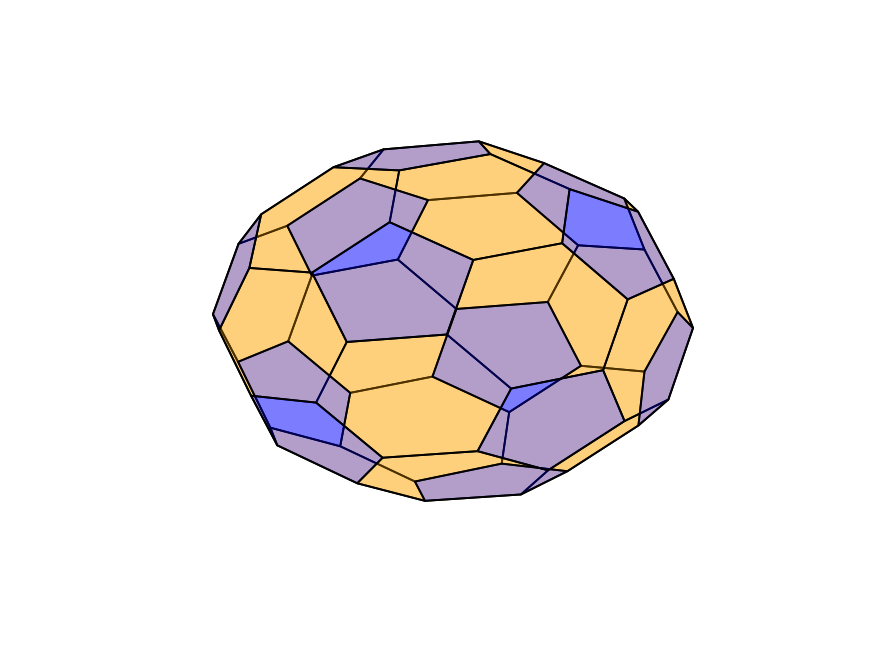

In [26]:
plotting_faces(X,pentagons,hexagons,ap=0.3,ah=0.3,ax_off=True)
